<a href="https://colab.research.google.com/github/thor4/neuralnets/blob/master/state_farm_task-step_1-clean_and_prep_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# State Farm Pre-employment Assessment
### *Model-based supervised learning binary classification task*
Your work will be evaluated in the following areas:
- The appropriateness of the steps you took
- The complexity of your models
- The performance of each model on the test set (using AUC)
- The organization and readability of your code
- The write-up comparing the models
---

## Step 1 - Clean and prepare your data
The data in this exercise have been simulated to mimic real, dirty data. Please clean the data with whatever method(s) you believe to be best/most suitable. Success in this exercise typically involves feature engineering and avoiding data leakage. You may create new features. However, you may not add or supplement with external data. 

We will begin by importing relevant libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer, QuantileTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer

Next, we use the pandas library to load our CSV data.

In [2]:
train_data = pd.read_csv("exercise_40_train.csv")
test_data = pd.read_csv("exercise_40_test.csv")

In [3]:
train_data.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100
0,0,0.165254,18.060003,Wed,1.077380,-1.339233,-1.584341,0.0062%,0.220784,1.816481,...,-0.397427,0.909479,no,5.492487,NaN,10.255579,7.627730,0,yes,104.251338
1,1,2.441471,18.416307,Friday,1.482586,0.920817,-0.759931,0.0064%,1.192441,3.513950,...,0.656651,9.093466,no,3.346429,4.321172,NaN,10.505284,1,yes,101.230645
2,1,4.427278,19.188092,Thursday,0.145652,0.366093,0.709962,-8e-04%,0.952323,0.782974,...,2.059615,0.305170,no,4.456565,NaN,8.754572,7.810979,0,yes,109.345215
3,0,3.925235,19.901257,Tuesday,1.763602,-0.251926,-0.827461,-0.0057%,-0.520756,1.825586,...,0.899392,5.971782,no,4.100022,1.151085,NaN,9.178325,1,yes,103.021970
4,0,2.868802,22.202473,Sunday,3.405119,0.083162,1.381504,0.0109%,-0.732739,2.151990,...,3.003595,1.046096,yes,3.234033,2.074927,9.987006,11.702664,0,yes,92.925935


### Prepare the data

Separate the predictors from the labels

In [5]:
train = train_data.drop("y", axis=1)
train_labels = train_data["y"].copy()

Drop unnecessary columns

In [6]:
train = train.drop(columns=["x39", "x99", "x79", "x28"])

Convert object columns to binary int64


In [7]:
binary_features = ["x24", "x31", "x93"]
for col in binary_features:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col].astype(str))

Replace null values in `x33` and `x77` with most likely value based on probabilities

In [8]:
for col in ["x33", "x77"]:
    probs = train[col].value_counts(normalize=True)
    missing = train[col].isna()
    train.loc[missing, col] = np.random.choice(probs.index, size=len(train[missing]), p=probs.values)

Combine duplicate days in `x3`

In [9]:
day_mapping = {
    "Mon": "Monday",
    "Tue": "Tuesday",
    "Wed": "Wednesday",
    "Thur": "Thursday",
    "Fri": "Friday",
    "Sat": "Saturday",
    "Sun": "Sunday"
}
train["x3"] = train["x3"].replace(day_mapping)

Convert the `x7` column to a float by removing the % sign and dividing by 100. Convert the `x19` column to a float by removing the $ sign.

In [20]:
train['x7'] = train['x7'].str.strip('%').astype(float) / 100
train['x19'] = train['x19'].str.strip('$').astype(float)

### Create and run preprocessing pipeline

In [90]:
# Define transformers for each group of columns
one_hot_features = ["x33", "x77", "x3", "x60", "x65"]
range_based_features = ["x58", "x67", "x71", "x84"]
quantile_transform_features = ["x12", "x18", "x61", "x92", "x40", "x57"]
log_transform_features = ["x14", "x16", "x21", "x42", "x45", "x55", "x70", "x73", "x75", "x82", "x89", "x96"]

one_hot_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("one_hot", OneHotEncoder())
])

def custom_discretizer(X, low_quantile=0.25, high_quantile=0.75):
    low_bound = np.quantile(X, low_quantile, axis=0)
    high_bound = np.quantile(X, high_quantile, axis=0)
    return np.where(X < low_bound, 0, np.where(X <= high_bound, 1, 2))

range_based_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("custom_discretizer", FunctionTransformer(custom_discretizer, validate=True)),
    ("one_hot", OneHotEncoder())
])

quantile_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("quantile_transform", QuantileTransformer(output_distribution="normal"))
])

def log1p_with_positive_shift(X):
    positive_shift = np.abs(np.min(X, axis=0)) + 1e-6
    return np.log1p(X + positive_shift)

log_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("log_transform", FunctionTransformer(log1p_with_positive_shift, validate=True)),
    ("standard_scaler", StandardScaler())
])

remaining_float_features = list(set(train.select_dtypes(include=["float64"]).columns) - set(range_based_features) - set(quantile_transform_features) - set(log_transform_features))

float_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("standard_scaler", StandardScaler())
])

# Create ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ("one_hot", one_hot_transformer, one_hot_features),
    ("range_based", range_based_transformer, range_based_features),
    ("quantile_transform", quantile_transformer, quantile_transform_features),
    ("log_transform", log_transformer, log_transform_features),
    ("float_transform", float_transformer, remaining_float_features)
])

# Apply the preprocessing pipeline
X_transformed = preprocessor.fit_transform(train)

# Get the column names from the transformers
one_hot_cols = preprocessor.named_transformers_["one_hot"].named_steps["one_hot"].get_feature_names_out(one_hot_features)
range_based_categories = ["low", "middle", "high"]
range_based_cols = [f"{col}_{cat}" for col in range_based_features for cat in range_based_categories]
quantile_transform_cols = [f"quantile_{col}" for col in quantile_transform_features]
log_transform_cols = [f"log_{col}" for col in log_transform_features]
float_transform_cols = [f"float_{col}" for col in remaining_float_features]

print("One-hot cols:", len(one_hot_cols))
print("Range-based cols:", len(range_based_cols))
print("Quantile transform cols:", len(quantile_transform_cols))
print("Log transform cols:", len(log_transform_cols))
print("Float transform cols:", len(float_transform_cols))

# Combine column names
columns = (list(one_hot_cols)
           + list(range_based_cols)
           + quantile_transform_cols
           + log_transform_cols
           + float_transform_cols)

print("Total expected columns:", len(columns))
print("Actual columns in transformed dataset:", X_transformed.shape[1])

train_transformed = pd.DataFrame(X_transformed, columns=columns)

One-hot cols: 82
Range-based cols: 12
Quantile transform cols: 6
Log transform cols: 12
Float transform cols: 64
Total expected columns: 176
Actual columns in transformed dataset: 176


In [92]:
train_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 176 entries, x33_Alabama to float_x41
dtypes: float64(176)
memory usage: 53.7 MB


In [93]:
train_transformed.columns[train_transformed.isnull().sum() != 0]

Index([], dtype='object')

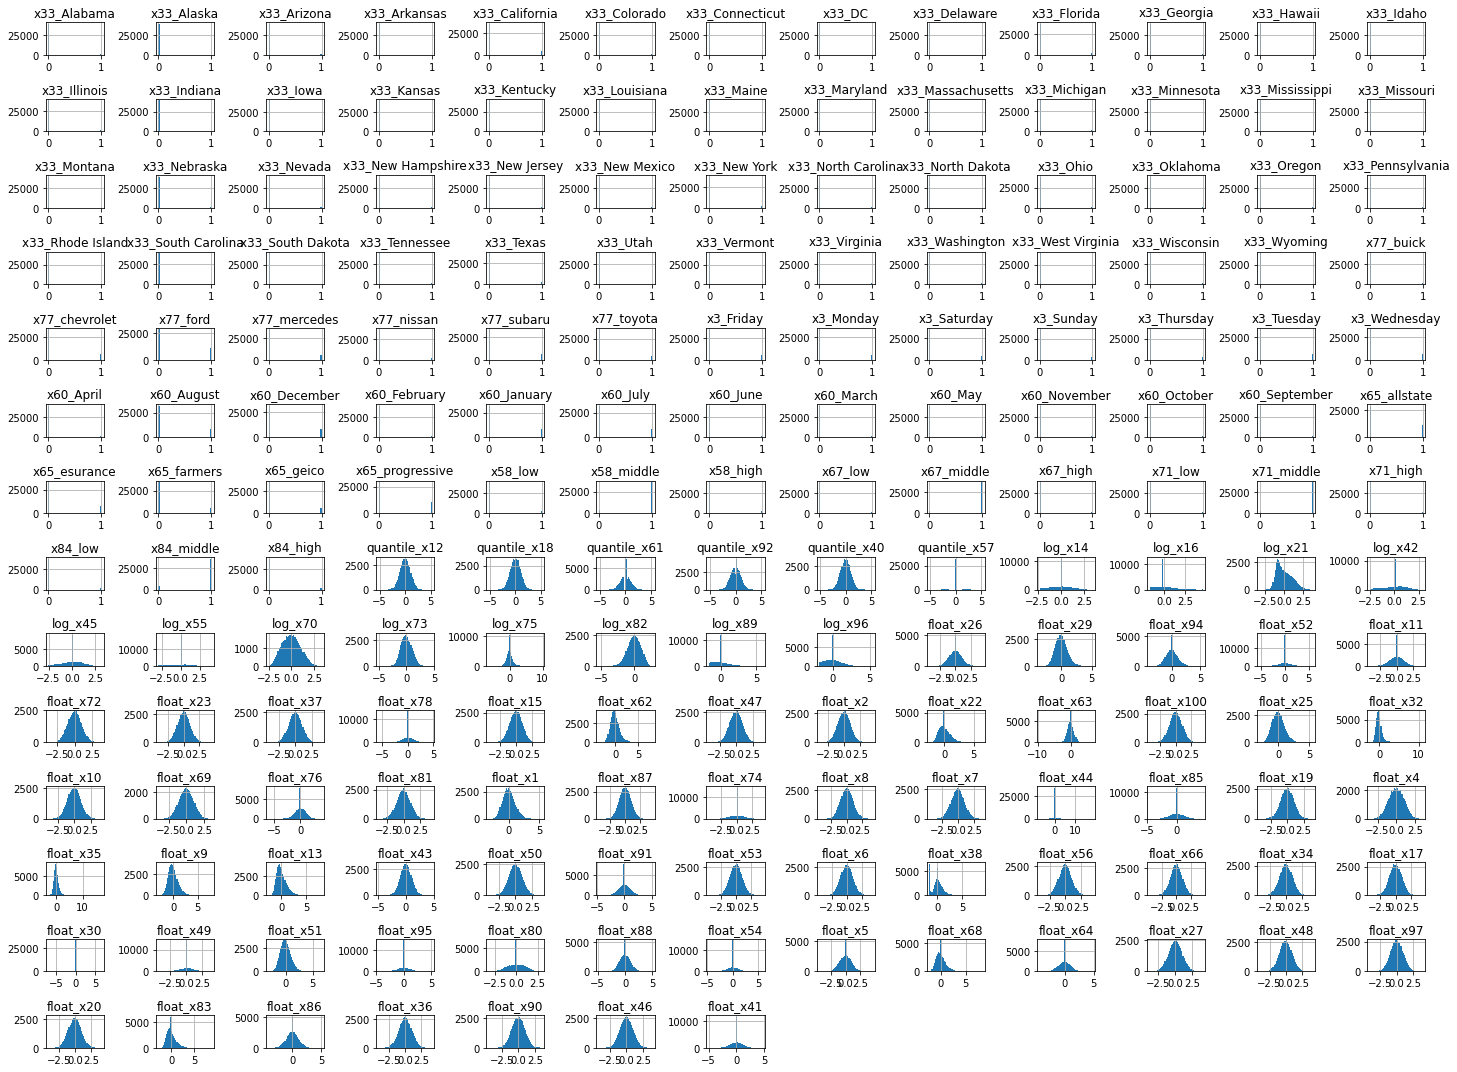

In [94]:
train_transformed.hist(bins=50, figsize=(20, 15))
plt.tight_layout()
plt.show()